In [2]:
import deepchem as dc
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio, IterativeStratifiedSplitter
from openpom.models.mpnn_pom import MPNNPOMModel
from datetime import datetime
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
import pubchempy as pcp

2025-02-21 09:51:41.296215: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 09:51:41.417789: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 09:51:41.541801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740127901.647216   33842 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740127901.676417   33842 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


/home/colin/anaconda3/envs/open_test/lib/python3.9/site-packages/torchvision-0.15.2-py3.9-linux-x86_64.egg/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/colin/anaconda3/envs/open_test/lib/python3.9/site-packages/torchvision-0.15.2-py3.9-linux-x86_64.egg/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major b

In [6]:
TASKS = [
'alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy',
'bergamot', 'berry', 'bitter', 'black currant', 'brandy', 'burnt',
'buttery', 'cabbage', 'camphoreous', 'caramellic', 'cedar', 'celery',
'chamomile', 'cheesy', 'cherry', 'chocolate', 'cinnamon', 'citrus', 'clean',
'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling',
'cortex', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy',
'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruit skin',
'fruity', 'garlic', 'gassy', 'geranium', 'grape', 'grapefruit', 'grassy',
'green', 'hawthorn', 'hay', 'hazelnut', 'herbal', 'honey', 'hyacinth',
'jasmin', 'juicy', 'ketonic', 'lactonic', 'lavender', 'leafy', 'leathery',
'lemon', 'lily', 'malty', 'meaty', 'medicinal', 'melon', 'metallic',
'milky', 'mint', 'muguet', 'mushroom', 'musk', 'musty', 'natural', 'nutty',
'odorless', 'oily', 'onion', 'orange', 'orangeflower', 'orris', 'ozone',
'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn',
'potato', 'powdery', 'pungent', 'radish', 'raspberry', 'ripe', 'roasted',
'rose', 'rummy', 'sandalwood', 'savory', 'sharp', 'smoky', 'soapy',
'solvent', 'sour', 'spicy', 'strawberry', 'sulfurous', 'sweaty', 'sweet',
'tea', 'terpenic', 'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable',
'vetiver', 'violet', 'warm', 'waxy', 'weedy', 'winey', 'woody'
]

print("No of tasks: ", len(TASKS))
n_tasks = len(TASKS)

No of tasks:  138


save train and test splits

# # uncomment and run if no splits saved yet

# # download curated dataset
#!wget https://raw.githubusercontent.com/ARY2260/openpom/main/openpom/data/curated_datasets/curated_GS_LF_merged_4983.csv

# # The curated dataset can also found at `openpom/data/curated_datasets/curated_GS_LF_merged_4983.csv` in the repo.

input_file = 'curated_GS_LF_merged_4983.csv' # or new downloaded file path

# # get dataset

featurizer = GraphFeaturizer()
smiles_field = 'nonStereoSMILES'
loader = dc.data.CSVLoader(tasks=TASKS,
                feature_field=smiles_field,
                featurizer=featurizer)
dataset = loader.create_dataset(inputs=[input_file])
n_tasks = len(dataset.tasks)

# # get train valid test splits
splitter = IterativeStratifiedSplitter(order=2)
train_dataset, test_dataset = splitter.train_test_split(dataset, frac_train=0.8, train_dir='./splits/train_data', test_dir='./splits/test_data')

print("train_dataset: ", len(train_dataset))
print("test_dataset: ", len(test_dataset))

load splits

In [4]:
train_dataset = dc.data.DiskDataset('./splits/train_data')
test_dataset = dc.data.DiskDataset('./splits/test_data')
print("train_dataset: ", len(train_dataset))
print("test_dataset: ", len(test_dataset))

train_dataset:  3989
test_dataset:  994


set parameters

In [7]:
from deepchem.metrics import Metric
from deepchem import metrics
train_ratios = get_class_imbalance_ratio(train_dataset)
assert len(train_ratios) == n_tasks

# learning_rate = 0.001
learning_rate = dc.models.optimizers.ExponentialDecay(initial_rate=0.001, decay_rate=0.5, decay_steps=32*20, staircase=True)

metric = Metric(metrics.roc_auc_score)

metrics_plu = [Metric(dc.metrics.accuracy_score), Metric(metrics.roc_auc_score), Metric(metrics.jaccard_score)]

# run this cell if detailed log is needed

import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [8]:
# no of models in the ensemble
n_layer = 5
n_models = 1

# no of epochs each model is trained for
nb_epoch = 30
i=3

In [12]:


for j in range(n_models):
    model = MPNNPOMModel(n_tasks = n_tasks,
                            batch_size=128,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = train_ratios,
                            loss_aggr_type = 'sum',
                            node_out_feats = 100,
                            edge_hidden_feats = 75,
                            edge_out_feats = 100,
                            num_step_message_passing = i+1,
                            mpnn_residual = True,
                            message_aggregator_type = 'sum',
                            mode = 'classification',
                            number_atom_features = GraphConvConstants.ATOM_FDIM,
                            number_bond_features = GraphConvConstants.BOND_FDIM,
                            n_classes = 1,
                            readout_type = 'global_sum_pooling',
                            ffn_hidden_list= [392, 392],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.12,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1e-5,
                            self_loop = False,
                            optimizer_name = 'adam',
                            log_frequency = 32,
                            model_dir = f'./tamp/ensemble_models_{i+1}_layer/experiments_{j+1}',
                            device_name='cpu')

    start_time = datetime.now()
    print("time start")
    
    # fit model
    loss = model.fit(
          train_dataset,
          nb_epoch=nb_epoch,
          max_checkpoints_to_keep=1,
          deterministic=False,
          restore=False)
    print("time end")
    end_time = datetime.now()
    
    train_scores = model.evaluate(train_dataset, [metric])['roc_auc_score']
    test_scores = model.evaluate(test_dataset, [metric])['roc_auc_score']
    print(f"loss = {loss}; train_scores = {train_scores}; test_scores = {test_scores}; time_taken = {str(end_time-start_time)}")
    model.save_checkpoint() # saves final checkpoint => `checkpoint2.pt`
    del model
    torch.cuda.empty_cache()

time start
time end
loss = 2.2291011810302734; train_scores = 0.9079013805698094; test_scores = 0.8915852570897367; time_taken = 0:29:57.834285


Get test score from the ensemble

In [76]:
list_preds = []
#dict_preds = {i : [] for i in range(1,n_layer+1)}
#models_dict={i : [] for i in range(1,n_layer+1)}
dict_preds = {4:[]}
models_dict={4:[]}
for j in range(n_models):
    model = MPNNPOMModel(n_tasks = n_tasks,
                            batch_size=128,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = train_ratios,
                            loss_aggr_type = 'sum',
                            node_out_feats = 100,
                            edge_hidden_feats = 75,
                            edge_out_feats = 100,
                            num_step_message_passing = i+1,
                            mpnn_residual = True,
                            message_aggregator_type = 'sum',
                            mode = 'classification',
                            number_atom_features = GraphConvConstants.ATOM_FDIM,
                            number_bond_features = GraphConvConstants.BOND_FDIM,
                            n_classes = 1,
                            readout_type = 'global_sum_pooling',
                            ffn_hidden_list= [392, 392],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.12,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1e-5,
                            self_loop = False,
                            optimizer_name = 'adam',
                            log_frequency = 32,
                            model_dir = f'./tamp/ensemble_models_{i+1}_layer/experiments_{j+1}',
                            device_name='cpu')
    model.restore(f"./tamp/ensemble_models_{i+1}_layer/experiments_{j+1}/checkpoint2.pt")
    test_scores = model.evaluate(test_dataset, metrics)#['roc_auc_score']
    models_dict[i+1].append(test_scores)
    
    #print("test_score: ", test_scores)
    preds = model.predict(test_dataset)
    #dict_preds[i+1].append(accuracy_score(preds,test_dataset.y))
    list_preds.append(preds)

preds_arr = np.asarray(list_preds)
ensemble_preds = np.mean(preds_arr, axis=0)
print("average ensemble score: ", roc_auc_score(test_dataset.y, ensemble_preds, average="macro"))

average ensemble score:  0.8915852570897367


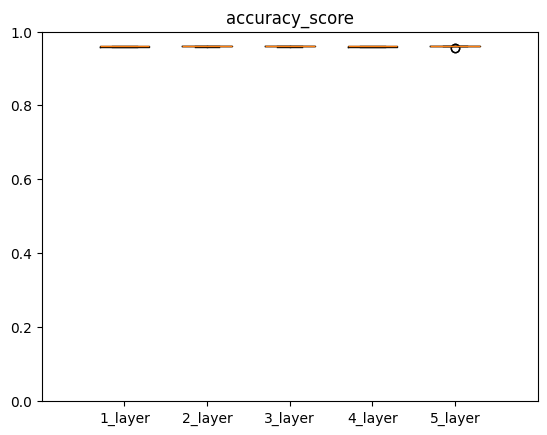

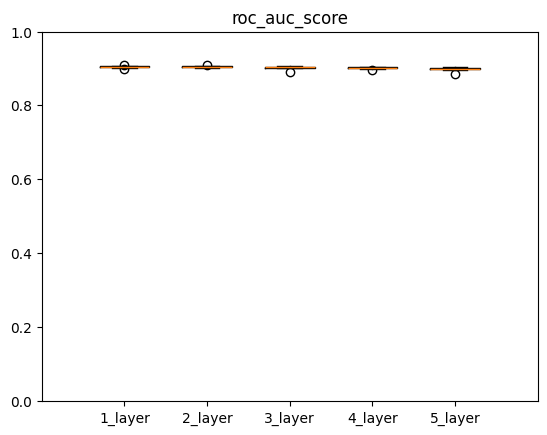

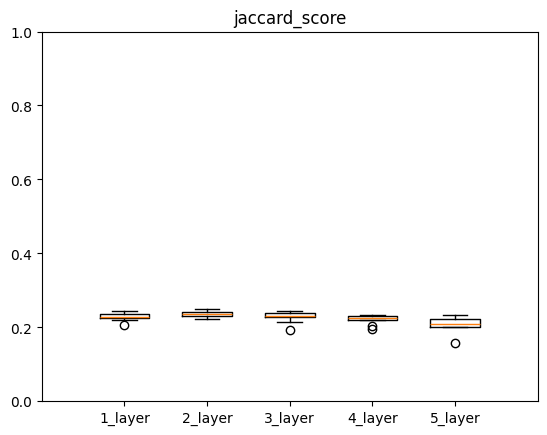

In [59]:
import matplotlib.pyplot as plt
for metr in ['accuracy_score','roc_auc_score', 'jaccard_score']:
    for (dim,scores) in models_dict.items():
        plt.boxplot([score[metr] for score in scores], positions=[dim], widths=0.6)
    plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in models_dict.keys()])
    plt.axis([0,6,0,1])
    plt.title(metr)
    plt.show()

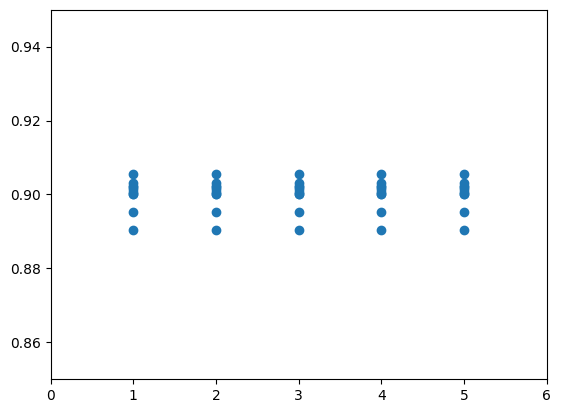

In [26]:
x = [dim for _ in scores for (dim,scores) in models_dict.items()]
y = [sc for sc in scores for (_,scores) in models_dict.items()]
plt.scatter(x,y)
plt.axis([0,6,0.85,0.95])
plt.show()

In [24]:
roc_auc_score(test_dataset.y, ensemble_preds, average="macro")

0.914704818729364

In [21]:
for (i,ar) in enumerate(list_preds):
    score = roc_auc_score(test_dataset.y, ar, average="macro")
    print("score moyen pour", i+1, " couche est de", score)    

score moyen pour 1  couche est de 0.8915852570897367


## Incorporation de la structure hiérarchique des odeurs
on utilise la bibliothéque rdflib pour les odeurs.

In [9]:
from rdflib import Graph
import cirpy
g = Graph()
g.parse("Fichiers-Sources/graph_odor.ttl")

<Graph identifier=Ne5948387ee3041d79dfe946824d16243 (<class 'rdflib.graph.Graph'>)>

In [5]:
# On récupére les odeurs feuilles 
query = """
    Select Distinct ?o WHERE {
        ?s rdfs:label ?o
        Filter(LANG(?o)="en") .
         FILTER NOT EXISTS{?cls rdfs:subClassOf ?s } .
    } """
Leaf_odor = []
for r in g.query(query):
        Leaf_odor.append(r[0])
print(len(Leaf_odor))

480


On transforme les CAS en smiles

In [117]:
odor_mol_df = pd.read_csv("Fichiers-Sources/OdorCAS.csv", delimiter="\t")
odor_mol_df['smiles'] = odor_mol_df["Unnamed: 0"]
Erreur = []
Smiles=[]
for cas in tqdm(odor_mol_df["Unnamed: 0"]):
    try:
        smile = cirpy.resolve(cas, 'smiles')
        Smiles.append(smile)
        if smile is None:
            print(f"cas {cas} est none")
        #odor_mol_df['smiles'] = smile
    except er:
        Erreur.append(cas)
        Smiles.append(np.nan)
        print(f'erreur = {er} {cas}')

odor_mol_df = odor_mol_df.drop('Unnamed: 0', axis=1)


  0%|                                                  | 0/3920 [00:00<?, ?it/s]


NameError: name 'er' is not defined

In [116]:
len(Erreur)

3920

In [36]:
pcp.get_compounds("64-17-5",'name')[0].isomeric_smiles

'CCO'

In [118]:
import pubchempy as pcp
df_od = pd.read_csv("Fichiers-Sources/OdorCAS.csv", delimiter="\t")
Erreur = []
Smiles=[]
for cas in tqdm(df_od["Unnamed: 0"]):
    try:
        smile = pcp.get_compounds(cas,'name')[0].isomeric_smiles
        Smiles.append(smile)
        if smile is None:
            print(f"cas {cas} est none")
        #odor_mol_df['smiles'] = smile
    except:
        Erreur.append(cas)
        Smiles.append(np.nan)
        print(cas)

df_od = df_od.drop('Unnamed: 0', axis=1)


 29%|███████████▎                           | 1134/3920 [09:14<21:02,  2.21it/s]

1334-78-7


 29%|███████████▎                           | 1136/3920 [09:15<19:44,  2.35it/s]

1335-44-0


 29%|███████████▍                           | 1154/3920 [09:26<22:29,  2.05it/s]

1500-94-3


 31%|████████████                           | 1217/3920 [09:59<19:32,  2.31it/s]

1866-31-5 (N)


 31%|████████████                           | 1218/3920 [10:00<19:20,  2.33it/s]

1866-31-5 (Z)


 31%|████████████▏                          | 1225/3920 [10:03<19:15,  2.33it/s]

1888-80-8


 37%|██████████████▎                        | 1436/3920 [11:49<20:30,  2.02it/s]

3508-83-6


 37%|██████████████▎                        | 1441/3920 [11:51<20:43,  1.99it/s]

3569-36-6


 40%|███████████████▌                       | 1564/3920 [12:53<17:33,  2.24it/s]

4798-44-1 (S)


 49%|███████████████████▏                   | 1931/3920 [15:59<15:01,  2.21it/s]

8013-90-9


 49%|███████████████████▏                   | 1932/3920 [15:59<14:02,  2.36it/s]

8024-27-9


 49%|███████████████████▏                   | 1933/3920 [15:59<13:33,  2.44it/s]

8030-89-5


 49%|███████████████████▏                   | 1934/3920 [16:00<13:16,  2.49it/s]

9003-73-0


 49%|███████████████████▎                   | 1935/3920 [16:00<12:49,  2.58it/s]

9005-80-5


 51%|███████████████████▊                   | 1991/3920 [16:30<16:25,  1.96it/s]

10448-24-5


 52%|████████████████████                   | 2022/3920 [16:47<14:57,  2.12it/s]

11028-42-5


 53%|████████████████████▌                  | 2066/3920 [17:10<15:09,  2.04it/s]

13678-56-3


 53%|████████████████████▌                  | 2070/3920 [17:12<14:50,  2.08it/s]

13678-63-2


 55%|█████████████████████▌                 | 2164/3920 [18:00<14:23,  2.03it/s]

15514-30-0


 57%|██████████████████████▏                | 2225/3920 [18:30<12:45,  2.22it/s]

17618-94-9


 60%|███████████████████████▍               | 2350/3920 [19:36<12:55,  2.02it/s]

20992-69-2


 61%|███████████████████████▋               | 2383/3920 [19:53<12:11,  2.10it/s]

22074-43-7


 64%|████████████████████████▊              | 2497/3920 [20:49<10:57,  2.17it/s]

26896-48-0


 64%|█████████████████████████▏             | 2527/3920 [21:05<11:17,  2.06it/s]

28631-86-9


 68%|██████████████████████████▍            | 2661/3920 [22:14<09:01,  2.32it/s]

35117-86-3


 68%|██████████████████████████▌            | 2674/3920 [22:21<09:23,  2.21it/s]

35250-78-3


 69%|███████████████████████████            | 2717/3920 [22:42<09:28,  2.12it/s]

37837-44-8


 70%|███████████████████████████▎           | 2742/3920 [22:54<08:21,  2.35it/s]

38888-81-2


 72%|████████████████████████████           | 2818/3920 [23:32<08:15,  2.22it/s]

41892-32-4


 73%|████████████████████████████▍          | 2860/3920 [23:53<07:47,  2.27it/s]

51371-47-2


 73%|███████████████████████▍        | 2876/3920 [1:10:55<244:58:26, 844.74s/it]

52089-55-1


 73%|████████████████████████▏        | 2880/3920 [1:10:57<58:41:41, 203.17s/it]

52435-37-7


 74%|█████████████████████████▊         | 2888/3920 [1:11:00<3:29:07, 12.16s/it]

52704-36-6


 75%|███████████████████████████▊         | 2946/3920 [1:11:29<08:28,  1.92it/s]

54830-99-8


 76%|████████████████████████████▏        | 2980/3920 [1:11:47<07:29,  2.09it/s]

56426-65-4


 77%|████████████████████████▌       | 3007/3920 [2:03:06<233:12:50, 919.57s/it]

57893-27-3


 77%|█████████████████████████▎       | 3013/3920 [2:03:09<27:22:34, 108.66s/it]

58214-97-4


 77%|████████████████████████████▌        | 3029/3920 [2:03:17<11:33,  1.28it/s]

59020-78-9


 80%|█████████████████████████████▌       | 3126/3920 [2:04:15<06:26,  2.05it/s]

63458-81-1


 81%|█████████████████████████████▊       | 3157/3920 [2:04:31<05:44,  2.21it/s]

65405-84-7


 81%|█████████████████████████████▉       | 3167/3920 [2:04:36<05:31,  2.27it/s]

65504-96-3


 81%|██████████████████████████████       | 3191/3920 [2:04:49<05:39,  2.15it/s]

66427-21-2


 81%|██████████████████████████████▏      | 3192/3920 [2:04:50<05:25,  2.24it/s]

66427-22-3


 82%|██████████████████████████████▏      | 3201/3920 [2:04:54<05:49,  2.06it/s]

67114-38-9


 83%|██████████████████████████████▌      | 3239/3920 [2:05:16<07:31,  1.51it/s]

68908-82-7


 85%|███████████████████████████████▎     | 3313/3920 [2:05:57<05:29,  1.84it/s]

68378-13-2


 85%|███████████████████████████████▍     | 3328/3920 [2:06:05<05:11,  1.90it/s]

68516-18-7


 85%|███████████████████████████████▍     | 3329/3920 [2:06:05<04:45,  2.07it/s]

68527-06-0


 85%|███████████████████████████████▌     | 3340/3920 [2:06:10<04:31,  2.14it/s]

68555-62-4


 85%|███████████████████████████████▌     | 3344/3920 [2:06:12<04:26,  2.16it/s]

68555-95-3


 85%|███████████████████████████████▌     | 3345/3920 [2:06:12<04:10,  2.29it/s]

68585-09-1


 85%|███████████████████████████████▌     | 3346/3920 [2:06:13<03:59,  2.40it/s]

68608-32-2


 85%|███████████████████████████████▌     | 3347/3920 [2:06:13<03:52,  2.47it/s]

68611-23-4


 85%|███████████████████████████████▌     | 3348/3920 [2:06:14<03:45,  2.54it/s]

68648-34-0


 86%|███████████████████████████████▋     | 3356/3920 [2:06:19<04:55,  1.91it/s]

68738-94-3


 86%|███████████████████████████████▊     | 3365/3920 [2:06:25<06:03,  1.53it/s]

68877-29-2


 86%|███████████████████████████████▊     | 3370/3920 [2:06:27<04:37,  1.98it/s]

68908-82-7


 86%|███████████████████████████████▊     | 3377/3920 [2:06:31<04:44,  1.91it/s]

68966-86-9


 86%|███████████████████████████████▉     | 3382/3920 [2:06:34<04:24,  2.03it/s]

69103-01-1


 87%|████████████████████████████████     | 3403/3920 [2:06:44<03:56,  2.18it/s]

70266-48-7


 87%|████████████████████████████████▏    | 3407/3920 [2:06:46<04:35,  1.86it/s]

70955-71-4


 87%|████████████████████████████████▎    | 3428/3920 [2:06:57<04:04,  2.01it/s]

71832-76-3


 88%|████████████████████████████████▍    | 3430/3920 [2:06:57<03:48,  2.14it/s]

71978-01-3


 88%|████████████████████████████████▌    | 3446/3920 [2:07:06<03:54,  2.02it/s]

72611-71-3


 88%|████████████████████████████████▌    | 3447/3920 [2:07:06<03:37,  2.18it/s]

72681-03-9


 88%|████████████████████████████████▋    | 3464/3920 [2:07:16<03:50,  1.98it/s]

73018-51-6


 89%|████████████████████████████████▊    | 3471/3920 [2:07:19<03:35,  2.08it/s]

73744-93-1


 90%|█████████████████████████████████▏   | 3514/3920 [2:07:44<03:21,  2.01it/s]

78053-99-3


 90%|█████████████████████████████████▏   | 3519/3920 [2:07:46<03:09,  2.12it/s]

79044-50-1


 90%|█████████████████████████████████▎   | 3526/3920 [2:07:50<03:06,  2.11it/s]

80449-58-7


 92%|█████████████████████████████████▉   | 3593/3920 [2:08:26<02:48,  1.94it/s]

88270-38-6


 92%|██████████████████████████████████   | 3613/3920 [2:08:38<02:59,  1.71it/s]

91771-62-9


 92%|██████████████████████████████████▏  | 3623/3920 [2:08:43<02:22,  2.08it/s]

93762-35-7


 93%|██████████████████████████████████▎  | 3630/3920 [2:08:46<02:22,  2.04it/s]

93905-03-4


 93%|██████████████████████████████████▍  | 3647/3920 [2:08:56<02:04,  2.19it/s]

94248-21-2


 93%|██████████████████████████████████▌  | 3656/3920 [2:09:00<02:02,  2.16it/s]

95654-18-5


 93%|██████████████████████████████████▌  | 3657/3920 [2:09:00<01:55,  2.28it/s]

95936-66-6


 93%|██████████████████████████████████▌  | 3660/3920 [2:09:02<02:00,  2.16it/s]

96508-09-7


 94%|██████████████████████████████████▊  | 3691/3920 [2:09:19<02:07,  1.80it/s]

107797-24-0


 94%|██████████████████████████████████▊  | 3692/3920 [2:09:20<02:19,  1.63it/s]

107797-25-1


 94%|██████████████████████████████████▉  | 3698/3920 [2:09:23<02:03,  1.80it/s]

108861-13-8


 95%|███████████████████████████████████  | 3714/3920 [2:09:32<01:40,  2.05it/s]

115482-83-2


 95%|███████████████████████████████████▏ | 3732/3920 [2:09:41<01:25,  2.20it/s]

124918-65-6


 95%|███████████████████████████████████▎ | 3736/3920 [2:09:43<01:26,  2.12it/s]

125352-06-9


 95%|███████████████████████████████████▎ | 3737/3920 [2:09:44<01:21,  2.25it/s]

125476-23-5


 95%|███████████████████████████████████▎ | 3738/3920 [2:09:44<01:17,  2.34it/s]

125476-24-6


 95%|███████████████████████████████████▎ | 3739/3920 [2:09:44<01:15,  2.39it/s]

125811-37-2


 96%|███████████████████████████████████▍ | 3748/3920 [2:09:49<01:20,  2.14it/s]

131222-75-8


 96%|███████████████████████████████████▍ | 3749/3920 [2:09:50<01:15,  2.26it/s]

131222-76-9


 96%|███████████████████████████████████▌ | 3766/3920 [2:09:59<01:19,  1.93it/s]

139164-92-4


 97%|███████████████████████████████████▊ | 3792/3920 [2:10:13<00:58,  2.20it/s]

168564-54-3


 98%|████████████████████████████████████ | 3826/3920 [2:10:32<00:46,  2.02it/s]

252736-39-3


 98%|████████████████████████████████████▏| 3833/3920 [2:10:35<00:38,  2.26it/s]

300371-33-9


 98%|████████████████████████████████████▎| 3843/3920 [2:10:40<00:36,  2.12it/s]

359794-78-8


 98%|████████████████████████████████████▍| 3857/3920 [2:10:47<00:30,  2.06it/s]

597532-53-1


 99%|████████████████████████████████████▍| 3866/3920 [2:10:51<00:26,  2.02it/s]

737776-59-9


 99%|████████████████████████████████████▍| 3867/3920 [2:10:52<00:24,  2.16it/s]

737776-68-0


 99%|████████████████████████████████████▋| 3881/3920 [2:11:00<00:20,  1.87it/s]

871465-49-5


 99%|████████████████████████████████████▋| 3884/3920 [2:11:01<00:14,  2.45it/s]

1094004-39-3


 99%|████████████████████████████████████▊| 3894/3920 [2:11:05<00:10,  2.55it/s]

977091-24-9


 99%|████████████████████████████████████▊| 3898/3920 [2:11:06<00:06,  3.59it/s]

1009814-14-5
1023288-21-2


 99%|████████████████████████████████████▊| 3899/3920 [2:11:07<00:05,  3.98it/s]

1064678-08-5


 99%|████████████████████████████████████▊| 3900/3920 [2:11:07<00:05,  3.55it/s]

1094004-39-3


100%|████████████████████████████████████▊| 3901/3920 [2:11:07<00:05,  3.33it/s]

1120363-98-5


100%|████████████████████████████████████▊| 3902/3920 [2:11:08<00:05,  3.13it/s]

1009814-14-5


100%|████████████████████████████████████▊| 3903/3920 [2:11:08<00:05,  2.97it/s]

1160112-20-8


100%|████████████████████████████████████▊| 3906/3920 [2:11:09<00:05,  2.48it/s]

1225070-56-3


100%|████████████████████████████████████▉| 3907/3920 [2:11:10<00:05,  2.52it/s]

1241905-19-0


100%|████████████████████████████████████▉| 3910/3920 [2:11:11<00:04,  2.10it/s]

1304037-63-5


100%|████████████████████████████████████▉| 3911/3920 [2:11:12<00:04,  2.23it/s]

1304037-68-0


100%|█████████████████████████████████████| 3920/3920 [2:11:16<00:00,  2.01s/it]


In [119]:
L = [1 for nan in Smiles if nan == np.nan]
len(Erreur)

111

In [129]:
SM = pd.DataFrame({"smiles" : Smiles})
data = df_od[:]
data = data.loc[:,(data.sum(axis=0)>=30)]
df_od = pd.concat([SM,data],axis=1)
print(df_od.shape)
df_od = df_od.dropna(subset=['smiles'])
print(df_od.shape)
df_od.to_csv('Mol_odeur.csv')

TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
TASKS = list(df_od.columns)
n_tasks = len(TASKS)
train_ratios = get_class_imbalance_ratio(train_dataset)

In [10]:
df_od = pd.read_csv('Mol_odeur.csv', index_col=0)
TASKS = list(df_od.columns)
TASKS.remove('smiles')

In [35]:
from rdflib import Graph
from pprint import pprint
g = Graph()
g.parse("Fichiers-Sources/graph_odor.ttl")
quer = """Select ?o Where{
    ?leaf rdfs:subClassOf ?odor .    
    FILTER EXISTS{?sub rdfs:subClassOf ?leaf  } .
    ?leaf rdfs:label ?o .
    FILTER(LANG(?o) = "en") .
}"""
Leaf = []
for result in g.query(quer):
    Leaf.append(result[0].toPython())
    pprint(result)

(rdflib.term.Literal('Citrus', lang='en'),)
(rdflib.term.Literal('Amine', lang='en'),)
(rdflib.term.Literal('Animal', lang='en'),)
(rdflib.term.Literal('Balsamic', lang='en'),)
(rdflib.term.Literal('Balsamic', lang='en'),)
(rdflib.term.Literal('Wood', lang='en'),)
(rdflib.term.Literal('Wood', lang='en'),)
(rdflib.term.Literal('Woody', lang='en'),)
(rdflib.term.Literal('Alcoholic Beverages', lang='en'),)
(rdflib.term.Literal('Cereal', lang='en'),)
(rdflib.term.Literal('Chemical', lang='en'),)
(rdflib.term.Literal('Cruciferous', lang='en'),)
(rdflib.term.Literal('Cruciferous', lang='en'),)
(rdflib.term.Literal('Cooked', lang='en'),)
(rdflib.term.Literal('Sweet', lang='en'),)
(rdflib.term.Literal('Empyreumatic', lang='en'),)
(rdflib.term.Literal('Spicy', lang='en'),)
(rdflib.term.Literal('Fermented', lang='en'),)
(rdflib.term.Literal('Tree Flower', lang='en'),)
(rdflib.term.Literal('Bush Flower', lang='en'),)
(rdflib.term.Literal('Floral', lang='en'),)
(rdflib.term.Literal('Fresh', lang='

In [52]:
gr = Graph()
gr.parse("Fichiers-Sources/graph_odor.ttl")
q = """
    SELECT DISTINCT ?o WHERE {
    FILTER NOT EXISTS{?sub rdfs:subClassOf ?s  } .
    ?s rdfs:label ?o .
    FILTER(LANG(?o) = "en")
}"""
M=[]
for r in gr.query(q):
    M.append(r[0].toPython())

dans les labels il n'y a pas que des odeurs mais aussi d'autres éléments qui possède des odeurs

# on va sélectionnner que les odeurs qui apparaisse au moins 30 fois

Avant de travailler sur la Strucure hiérachique on tout d'abord donné l'ensemble des donné pour avoir un point de comparaison

de façon harbitraire on va définir le nombre de couche à 3

In [123]:
from deepchem.metrics import Metric
from deepchem import metrics
input_file = 'Mol_odeur.csv' # or new downloaded file path

# # get dataset

featurizer = GraphFeaturizer()
smiles_field = 'smiles'
loader = dc.data.CSVLoader(tasks=TASKS,
                feature_field=smiles_field,
                featurizer=featurizer)

dataset = loader.create_dataset(inputs=[input_file])
n_tasks = len(dataset.tasks)

# # get train valid test splits
splitter = IterativeStratifiedSplitter(order=2)
train_dataset, test_dataset = splitter.train_test_split(dataset, frac_train=0.8)

train_ratios = get_class_imbalance_ratio(train_dataset)
assert len(train_ratios) == n_tasks

print("train_dataset: ", len(train_dataset))
print("test_dataset: ", len(test_dataset))

i
train_dataset:  3007
test_dataset:  802


In [11]:
n_models=5
learning_rate = 0.001
nb_epoch=30

In [131]:
from tqdm import tqdm
for i in tqdm(range(n_models)):
    model_sketch = MPNNPOMModel(n_tasks = n_tasks,
                            batch_size=128,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = train_ratios,
                            loss_aggr_type = 'sum',
                            node_out_feats = 100,
                            edge_hidden_feats = 75,
                            edge_out_feats = 100,
                            num_step_message_passing = 3,
                            mpnn_residual = True,
                            message_aggregator_type = 'sum',
                            mode = 'classification',
                            number_atom_features = GraphConvConstants.ATOM_FDIM,
                            number_bond_features = GraphConvConstants.BOND_FDIM,
                            n_classes = 1,
                            readout_type = 'set2set',
                            num_step_set2set = 3,
                            num_layer_set2set = 2,
                            ffn_hidden_list= [392, 392],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.12,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1e-5,
                            self_loop = False,
                            optimizer_name = 'adam',
                            log_frequency = 32,
                            model_dir = f'./sketchOscent/model_sans_hier/model_{i}',
                            device_name='cpu')

    start_time = datetime.now()
    print("time start")
    
    # fit model
    loss = model_sketch.fit(
          train_dataset,
          nb_epoch=nb_epoch,
          max_checkpoints_to_keep=1,
          deterministic=False,
          restore=False)
    print("time end")
    end_time = datetime.now()
    
    train_scores = model_sketch.evaluate(train_dataset, metrics_plu)
    test_scores = model_sketch.evaluate(test_dataset, metrics_plu)
    print(f"loss = {loss}; train_scores = {train_scores}; test_scores = {test_scores}; time_taken = {str(end_time-start_time)}")
    model_sketch.save_checkpoint() # saves final checkpoint => `checkpoint2.pt`
    del model_sketch
    torch.cuda.empty_cache()

  0%|                                                     | 0/5 [00:00<?, ?it/s]

time start
time end


 20%|████████▏                                | 1/5 [18:03<1:12:14, 1083.63s/it]

loss = 2.37528920173645; train_scores = {'accuracy_score': 0.9659913535084803, 'roc_auc_score': 0.9279253624898189, 'jaccard_score': 0.23724479209318855}; test_scores = {'accuracy_score': 0.9614364089775562, 'roc_auc_score': 0.902678165313144, 'jaccard_score': 0.21742296902031114}; time_taken = 0:17:40.741682
time start
time end


 40%|████████████████▍                        | 2/5 [45:52<1:11:23, 1427.87s/it]

loss = 2.459259271621704; train_scores = {'accuracy_score': 0.9651400066511474, 'roc_auc_score': 0.9205504388173293, 'jaccard_score': 0.2086777194097995}; test_scores = {'accuracy_score': 0.9607182044887783, 'roc_auc_score': 0.9006236900523389, 'jaccard_score': 0.20062233536675075}; time_taken = 0:27:27.265842
time start
time end


 60%|████████████████████████▌                | 3/5 [1:05:52<44:07, 1323.80s/it]

loss = 2.436873435974121; train_scores = {'accuracy_score': 0.9653209178583306, 'roc_auc_score': 0.9235738190645277, 'jaccard_score': 0.21431660254785334}; test_scores = {'accuracy_score': 0.9616758104738157, 'roc_auc_score': 0.9049719098406434, 'jaccard_score': 0.20965868597867088}; time_taken = 0:19:37.868554
time start
time end


 80%|████████████████████████████████▊        | 4/5 [1:24:12<20:35, 1235.48s/it]

loss = 2.45409893989563; train_scores = {'accuracy_score': 0.9656375124709012, 'roc_auc_score': 0.9208950914831016, 'jaccard_score': 0.20623501048152873}; test_scores = {'accuracy_score': 0.961187032418953, 'roc_auc_score': 0.8976848587941915, 'jaccard_score': 0.1985836943427057}; time_taken = 0:17:57.011368
time start
time end


100%|█████████████████████████████████████████| 5/5 [1:42:19<00:00, 1227.91s/it]

loss = 2.392061710357666; train_scores = {'accuracy_score': 0.9662387761888925, 'roc_auc_score': 0.9256131435025874, 'jaccard_score': 0.218307245583731}; test_scores = {'accuracy_score': 0.9614663341645887, 'roc_auc_score': 0.903484542372331, 'jaccard_score': 0.20715432320933666}; time_taken = 0:17:44.255369


In [13]:
list_preds = []
dict_preds = {i : [] for i in range(1,n_layer+1)}
models_dict={i : [] for i in range(1,n_layer+1)}
for i in tqdm(range(n_layer)):
    for j in range(n_models):
        model_sketch = MPNNPOMModel(n_tasks = n_tasks,
                                batch_size=128,
                                learning_rate=learning_rate,
                                class_imbalance_ratio = train_ratios,
                                loss_aggr_type = 'sum',
                                node_out_feats = 100,
                                edge_hidden_feats = 75,
                                edge_out_feats = 100,
                                num_step_message_passing = i+1,
                                mpnn_residual = True,
                                message_aggregator_type = 'sum',
                                mode = 'classification',
                                number_atom_features = GraphConvConstants.ATOM_FDIM,
                                number_bond_features = GraphConvConstants.BOND_FDIM,
                                n_classes = 1,
                                readout_type = 'set2set',
                                num_step_set2set = 3,
                                num_layer_set2set = 2,
                                ffn_hidden_list= [392, 392],
                                ffn_embeddings = 256,
                                ffn_activation = 'relu',
                                ffn_dropout_p = 0.12,
                                ffn_dropout_at_input_no_act = False,
                                weight_decay = 1e-5,
                                self_loop = False,
                                optimizer_name = 'adam',
                                log_frequency = 32,
                                model_dir = f'./sketchOscent/model_sans_hier/model_{i}',
                                device_name='cpu')
        model_sketch.restore(f"./sketchOscent/model_sans_hier/model_{i}/checkpoint2.pt")
        test_scores = model_sketch.evaluate(test_dataset, metrics_plu)#['roc_auc_score']
        models_dict[i+1].append(test_scores)
        
        #print("test_score: ", test_scores)
        preds = model_sketch.predict(test_dataset)
        #dict_preds[i+1].append(accuracy_score(preds,test_dataset.y))
        list_preds.append(preds)


  0%|                                                     | 0/5 [00:00<?, ?it/s]


RuntimeError: Error(s) in loading state_dict for MPNNPOM:
	size mismatch for ffn.linears.3.weight: copying a param with shape torch.Size([125, 256]) from checkpoint, the shape in current model is torch.Size([138, 256]).
	size mismatch for ffn.linears.3.bias: copying a param with shape torch.Size([125]) from checkpoint, the shape in current model is torch.Size([138]).

In [72]:
df_od = pd.read_csv('Mol_odeur.csv', index_col=0)
df_od.shape

(3809, 126)

In [20]:
from rdflib import Graph
df_od = pd.read_csv('Mol_odeur.csv')
g = Graph()
g.parse("Fichiers-Sources/graph_odor.ttl")
quer = """Select s Where{
    ?leaf rdfs:subClassOf ?odor .
    ?leaf rdfs:label ?o .
    FILTER NOT EXISTS{?sub rdfs:subClassOf ?leaf FILTER(?sub != ?leaf && ?sub != owl:Nothing ) } .
    FILTER(LANG(?o) = "en") .
}"""
Leaf = []
for result in g.query(quer):
    Leaf.append(result[0].toPython())

In [19]:
from rdflib import Graph
df_od = pd.read_csv('Mol_odeur.csv', index_col=0)
g = Graph()
g.parse("Fichiers-Sources/graph_odor.ttl")
Individuals = []
q = """Select ?s Where{
    ?s a ?o .
    ?o rdf:type rdfs:Class
}"""
for res in g.query(q):
    Individuals.append(res[0].fragment)

Individuals.sort()
Not_Individuals = [label for label in df_od.columns if label not in Individuals]
Not_Individuals.remove('smiles')
df_od = df_od.drop(Not_Individuals, axis=1)
TASKS = list(df_od.columns)
TASKS.remove('smiles')
df_od.to_csv('Individual_label.csv')

### On supprime les odeurs qui ne sont pas des noeuds

In [22]:
from deepchem.metrics import Metric
from deepchem import metrics
input_file = 'Individual_label.csv' # or new downloaded file path

# # get dataset

featurizer = GraphFeaturizer()
smiles_field = 'smiles'
loader = dc.data.CSVLoader(tasks=TASKS,
                feature_field=smiles_field,
                featurizer=featurizer)
dataset = loader.create_dataset(inputs=[input_file])
n_tasks = len(dataset.tasks)

# # get train valid test splits
#splitter = IterativeStratifiedSplitter(order=2)
#train_dataset, test_dataset = splitter.train_test_split(dataset, frac_train=0.8, train_dir='./Dataset_Hier/splits/train_data', test_dir='./Dataset_Hier/splits/test_data')
train_dataset = dc.data.DiskDataset('/Dataset_Hier/splits/train_data')
test_dataset = dc.data.DiskDataset('./Dataset_Hier/splits/test_data')
train_ratios = get_class_imbalance_ratio(train_dataset)
assert len(train_ratios) == n_tasks

print("train_dataset: ", len(train_dataset))
print("test_dataset: ", len(test_dataset))

ValueError: No Metadata Found On Disk

In [25]:
n_tasks = len(dataset.tasks)

# # get train valid test splits
#splitter = IterativeStratifiedSplitter(order=2)
#train_dataset, test_dataset = splitter.train_test_split(dataset, frac_train=0.8, train_dir='./Dataset_Hier/splits/train_data', test_dir='./Dataset_Hier/splits/test_data')
train_dataset = dc.data.DiskDataset('./Dataset_Hier/splits/train_data')
test_dataset = dc.data.DiskDataset('./Dataset_Hier/splits/test_data')
train_ratios = get_class_imbalance_ratio(train_dataset)
assert len(train_ratios) == n_tasks

print("train_dataset: ", len(train_dataset))
print("test_dataset: ", len(test_dataset))

train_dataset:  3047
test_dataset:  762


In [33]:
from tqdm import tqdm
Models_list = []
for i in tqdm(range(n_models)):
    model_sketch = MPNNPOMModel(n_tasks = n_tasks,
                            batch_size=128,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = train_ratios,
                            loss_aggr_type = 'sum',
                            node_out_feats = 100,
                            edge_hidden_feats = 75,
                            edge_out_feats = 100,
                            num_step_message_passing = 3,
                            mpnn_residual = True,
                            message_aggregator_type = 'sum',
                            mode = 'classification',
                            number_atom_features = GraphConvConstants.ATOM_FDIM,
                            number_bond_features = GraphConvConstants.BOND_FDIM,
                            n_classes = 1,
                            readout_type = 'global_sum_pooling',
                            ffn_hidden_list= [392, 392],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.12,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1e-5,
                            self_loop = False,
                            optimizer_name = 'adam',
                            log_frequency = 32,
                            model_dir = f'./sketchOscent/model_avec_hier/model_{i}',
                            device_name='cpu')

    start_time = datetime.now()
    print("time start")
    
    # fit model
    loss = model_sketch.fit(
          train_dataset,
          nb_epoch=nb_epoch,
          max_checkpoints_to_keep=1,
          deterministic=False,
          restore=False)
    print("time end")
    end_time = datetime.now()
    
    train_scores = model_sketch.evaluate(train_dataset, metrics_plu)
    test_scores = model_sketch.evaluate(test_dataset, metrics_plu)
    print(f"loss = {loss}; train_scores = {train_scores}; test_scores = {test_scores}; time_taken = {str(end_time-start_time)}")
    model_sketch.save_checkpoint() # saves final checkpoint => `checkpoint2.pt`
    Models_list.append(model_sketch)
    del model_sketch
    torch.cuda.empty_cache()

  0%|                                                     | 0/5 [00:00<?, ?it/s]

time start
time end


 20%|████████▏                                | 1/5 [19:54<1:19:38, 1194.51s/it]

loss = 1.015133023262024; train_scores = {'accuracy_score': 0.9716756324824132, 'roc_auc_score': 0.8705340510302315, 'jaccard_score': 0.05947136819810077}; test_scores = {'accuracy_score': 0.9685800144547149, 'roc_auc_score': 0.8554322272278547, 'jaccard_score': 0.050516642728076204}; time_taken = 0:19:36.072867
time start
time end


 40%|█████████████████▏                         | 2/5 [39:42<59:31, 1190.62s/it]

loss = 0.9671229124069214; train_scores = {'accuracy_score': 0.9731073091613041, 'roc_auc_score': 0.8693285619576752, 'jaccard_score': 0.06371677762581555}; test_scores = {'accuracy_score': 0.9695119631785156, 'roc_auc_score': 0.8663299539597509, 'jaccard_score': 0.05638870215347384}; time_taken = 0:19:29.732509
time start
time end


 60%|█████████████████████████▊                 | 3/5 [59:47<39:54, 1197.11s/it]

loss = 1.0617328882217407; train_scores = {'accuracy_score': 0.9725508102528977, 'roc_auc_score': 0.8370407603330768, 'jaccard_score': 0.03229093453981426}; test_scores = {'accuracy_score': 0.9683137433907718, 'roc_auc_score': 0.8238749007445632, 'jaccard_score': 0.028190935883904495}; time_taken = 0:19:45.647788
time start
time end


 80%|████████████████████████████████▊        | 4/5 [1:20:31<20:15, 1215.73s/it]

loss = 0.9717450141906738; train_scores = {'accuracy_score': 0.9732928087974391, 'roc_auc_score': 0.8831788758838014, 'jaccard_score': 0.08013108531122522}; test_scores = {'accuracy_score': 0.9698923504127202, 'roc_auc_score': 0.8777736581163909, 'jaccard_score': 0.07141136118739774}; time_taken = 0:20:23.388142
time start
time end


100%|█████████████████████████████████████████| 5/5 [1:40:57<00:00, 1211.52s/it]

loss = 0.9631438851356506; train_scores = {'accuracy_score': 0.9736923464752689, 'roc_auc_score': 0.88785810691784, 'jaccard_score': 0.08290319998464701}; test_scores = {'accuracy_score': 0.970405873178896, 'roc_auc_score': 0.8768105425020083, 'jaccard_score': 0.07099183080793071}; time_taken = 0:20:06.226524


Pour chaque label, qui n'est pas une feuille on va chercher si la feuille est présente dans ce cas on met à 1 sinon 0

In [150]:
df_test = pd.read_csv('Mol_odeur.csv')

In [27]:
def guess(Dataset, Predictions, Not_individuals, graph_ttl=g):
    Predictions = (Predictions > 0.5).astype(int)
    nb_ligne, nb_columns = Predictions.shape
    New_Prediction = np.concatenate( (Predictions, np.zeros((nb_ligne, len(Not_individuals) ))), axis=1 )
    df_pred = pd.DataFrame(New_Prediction, columns=list(Dataset.tasks) + Not_individuals)
    for col in Dataset.tasks:
        quer = f""" 
        Select ?od_parent WHERE {{ 
            :{col} a ?od_parent . 
        }} """
        for res in g.query(quer):
            q = f"""
                Select ?parent WHERE{{ 
                    :{res[0].fragment} rdfs:subClassOf ?parent
                    }}
            """
            for res2 in g.query(q):
                if res2[0].fragment in Not_individuals:
                    df_pred[res2[0].fragment] = df_pred[res2[0].fragment] + df_pred[col]
    df_pred.applymap(lambda x: 1 if isinstance(x,int) and x>=1 else x )
    Smiles = pd.DataFrame({"smiles" : Dataset.ids}) 
    return pd.concat([Smiles,df_pred.reindex(sorted(df_pred.columns), axis=1)], axis=1)
                
    

In [28]:
model_sketch = MPNNPOMModel(n_tasks = n_tasks,
                        batch_size=128,
                        learning_rate=learning_rate,
                        class_imbalance_ratio = train_ratios,
                        loss_aggr_type = 'sum',
                        node_out_feats = 100,
                        edge_hidden_feats = 75,
                        edge_out_feats = 100,
                        num_step_message_passing = 3,
                        mpnn_residual = True,
                        message_aggregator_type = 'sum',
                        mode = 'classification',
                        number_atom_features = GraphConvConstants.ATOM_FDIM,
                        number_bond_features = GraphConvConstants.BOND_FDIM,
                        n_classes = 1,
                        readout_type = 'global_sum_pooling',
                        ffn_hidden_list= [392, 392],
                        ffn_embeddings = 256,
                        ffn_activation = 'relu',
                        ffn_dropout_p = 0.12,
                        ffn_dropout_at_input_no_act = False,
                        weight_decay = 1e-5,
                        self_loop = False,
                        optimizer_name = 'adam',
                        log_frequency = 32,
                        model_dir = f'./sketchOscent/model_avec_hier/model_4',
                        device_name='cpu')
model_sketch.restore("./sketchOscent/model_avec_hier/model_4/checkpoint2.pt")

In [29]:
pred=model_sketch.predict(test_dataset)

In [30]:
n_pred = guess(test_dataset, pred, Not_Individuals, g)

In [31]:
n_pred

,smiles,Agrume,Aldehyde,Alliace,Animal,Anise,Baie,Balsamique,Banane,Beurre,...,santal,savon,tabac,the,tomate,vanille,vert,vetiver,vin,violette
0,C([C@H]([C@H]([C@@H]([C@H](CO)O)O)O)O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C1=CC(=CC=C1CCN)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C(CC(=O)O)CN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C(C(=O)O)N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C[C@@H](C(=O)O)N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,CCCCOC(=O)/C=C/C1=CC=CC=C1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
758,C1=CC=C(C=C1)CSCC2=CC=CC=C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
759,COCC1=CC=CC=C1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
760,CCOCC1=CC=CC=C1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [45]:
def get_file(data_frame, file_name ='Mol_odeur.csv'):
    Labels = list(data_frame.columns)
    df = pd.read_csv(file_name, usecols=Labels)
    print(len(df.index) - len(df['smiles'].unique()))
    return df.filter(items=data_frame['smiles'], axis=0)
    

In [46]:
df = get_file(n_pred)
df

185


,smiles,Agrume,Aldehyde,Alliace,Animal,Anise,Baie,Balsamique,Banane,Beurre,...,santal,savon,tabac,the,tomate,vanille,vert,vetiver,vin,violette


In [89]:
import sklearn
sklearn.metrics.accuracy_score(n_pred.values, test_dataset.y[1])

ValueError: Found input variables with inconsistent numbers of samples: [125, 69]

In [90]:
test_dataset.y.shape

(762, 69)

In [47]:
n_pred.index

RangeIndex(start=0, stop=762, step=1)

In [58]:
df_test = pd.read_csv("Fichiers-Sources/OdorCAS.csv", delimiter="\t")
df_test[df_test.duplicated()]

,Unnamed: 0,Acetique,Agrume,Aldehyde,Alliace,Amande_Amere,Animal,Anise,Baie,Balsamique,...,verveine,vetiver,vin,vinaigre,violette,wasabi,whisky,yaourt,ylang_ylang,zeste_citron
1450,491-01-0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2099,87-91-2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2164,97-41-6,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2216,17369-59-4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2253,10519-33-2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,770-27-4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3885,97231-35-1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3899,1094004-39-3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3901,1009814-14-5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
